# Пример решения задачи "Catch Me If You Can" 

Алексей Ельчанинов

Подробное описание условий задачи [здесь](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). Коротко: необходимо идентифицировать взломщика в сети по его поведению. Дана сессия из 10 сайтов и время их посещений. Метрика - roc auc.

### Импортируем необходимые библиотеки

In [4]:
import math
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
# import eli5
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, train_test_split, validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
import warnings
warnings.filterwarnings('ignore')
# import xgboost as xgb
# from catboost import CatBoostClassifier
import seaborn as sns

### Импортируем данные

In [5]:
PATH_TO_DATA = '' 
SEED = 17   
SITE_NGRAMS = (1, 5)    # устанавливаются оптимальные значения, найденные в ходе решения
MAX_FEATURES = 50000    
BEST_LOGIT_C = 3.9810717055349722
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
test_df = pd.read_csv('catch_me_test_sessions.csv',index_col='session_id', parse_dates=times)
train_df = pd.read_csv('catch_me_train_sessions.csv',index_col='session_id', parse_dates=times)
train_df = train_df.sort_values(by='time1') # чтобы не прогнозировать из будующего в прошлое
y_train = train_df['target']

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [212]:
train_df.shape

(253561, 21)

Дисбаланс классов

In [5]:
np.mean(y_train)

0.00905896411514389

Номера в колонках site соответствуют назваю сайта в словаре site_dic.pkl. Сайты, которые посещал пользователь являются хорошими признаками для идентификации взломщика.

### Разбиваем данные на два DataFrame, применяем подход TF-IDF к "мешку сайтов"

In [7]:
def prepare_sparse_features(train_df, test_df, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    with open(r"Desktop/dataset/site_dic.pkl", "rb") as input_file:
        site_dict = pickle.load(input_file)
    id2sites = {i:k for k,i in site_dict.items()}
    id2sites[0] = 'unknown'
    sites = ['site%s' % i for i in range(1, 11)]
    train_session = train_df[sites].fillna(0).astype(int).apply(lambda row:
                                                                ' '.join([id2sites[i] for i in row]), axis = 1).tolist()
    test_session = test_df[sites].fillna(0).astype(int).apply(lambda row:
                                                                ' '.join([id2sites[i] for i in row]), axis = 1).tolist()
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_session)
    X_test = vectorizer.transform(test_session)
    y_train = train_df['target'].astype(int).values
    train_times, test_times = train_df[times], test_df[times]
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [8]:
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = \
        prepare_sparse_features(train_df,test_df,
            path_to_site_dict=os.path.join('Desktop/dataset/site_dic.pkl'),
            vectorizer_params={'ngram_range': SITE_NGRAMS,
                               'max_features': MAX_FEATURES,
                               'tokenizer': lambda s: s.split()})
                                


FileNotFoundError: [Errno 2] No such file or directory: 'Desktop/dataset/site_dic.pkl'

### Генерируем признаки из времени, те, что помечены как коментарий - не сработали
Предпологаем, что взломщики имеют какую-либо закономерность во времени посещения сайтов и продолжительности сессий.

In [20]:
def times_features (times):
    new_features_time = pd.DataFrame()
    new_features_time['hour'] = times['time1'].apply(lambda ts: ts.hour)
    new_features_time['morning'] = ((new_features_time['hour'] >= 7) & (new_features_time['hour'] <= 11)).astype('int')
    new_features_time['day'] = ((new_features_time['hour'] >= 12) & (new_features_time['hour'] <= 18)).astype('int')
    new_features_time['evening'] = ((new_features_time['hour'] >= 19) & (new_features_time['hour'] <= 23)).astype('int')
    new_features_time['sess_duration'] = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int')
    new_features_time['day_of_week'] = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
#    new_features_time['weekend'] = times['time1'].apply(lambda t: t.weekday()).isin([5,6]).astype('int')
    new_features_time['month'] = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    new_features_time['year_month'] = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    new_features_time.drop('hour', axis = 1, inplace = True) 
    return new_features_time


### Гистограммы признаков
Проверяем, чтобы наши признаки давали прирост информации

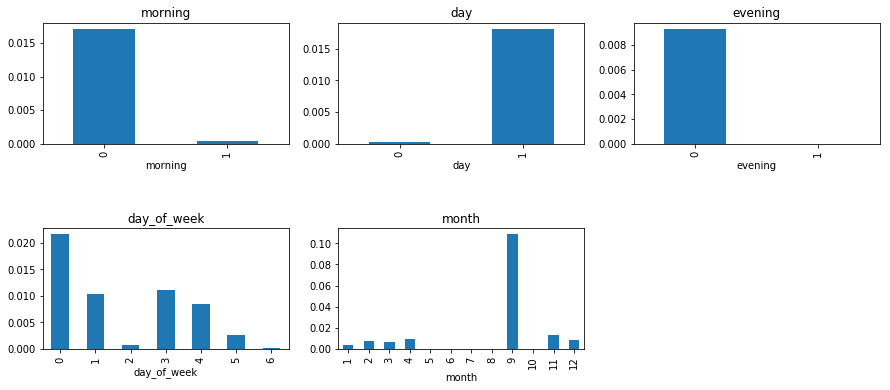

In [209]:
train_features['y'] = y_train
fig = plt.figure(figsize = (15,6))
for i, col in enumerate (train_features.columns.drop('y').drop('sess_duration').drop('year_month')):
    ax = fig.add_subplot(2,3, i+1)
    ax.set_title(col)
    train_features.groupby(col)['y'].mean().plot(kind = 'bar')
plt.subplots_adjust(hspace=0.7, wspace=0.2)
train_features.drop('y', axis = 1, inplace = True)

### Масштабируем столбцы с значениями больше единицы

In [10]:
def scaled_pd (x_train, x_test):
    if c == 1:
        scaler = StandardScaler()
    x_train_new = scaler.fit_transform(x_train.values.reshape(-1,1))
    x_test_new = scaler.transform(x_test.values.reshape(-1,1))
    return x_train_new, x_test_new

In [2]:
def scaler_cv (train_features,test_features):
    for i in train_features.columns:
        if train_features[i].max() > 1:
            train_features[i] , test_features[i] = scaled_pd(train_features[i],test_features[i])
    return train_features, test_features

In [54]:
train_features = times_features(train_times)
test_features = times_features(test_times)

In [7]:
train_features, test_features = scaler_cv (train_features,test_features)

### Валидация

Данные имеют временную составляющую, поэтому необходимо в качестве кросс-валидации применять фуркцию TimeSeriesSplit.

Распределение целевого класса по выборке

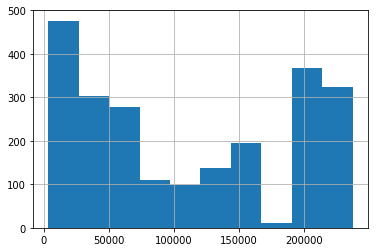

In [29]:
i = np.where(y_train == 1)
pd.Series(i).hist();

Дисбаланс классов большой, поэтому при выборе числа сплитов необходимо, что бы целевая переменная была равномерно распределена по сплитам.

In [223]:
time_split = TimeSeriesSplit(n_splits=10)

In [224]:
for train_ind , valid_ind in time_split.split(train_features, y_train):
    print ('train ',np.mean(y_train[train_ind]),' valid ', np.mean(y_train[valid_ind]) )

train  0.008850325379609544  valid  0.00967420068543664
train  0.009262271968070107  valid  0.008676413170795193
train  0.009066982878297084  valid  0.009804346882998569
train  0.009251325878767503  valid  0.008806559368357121
train  0.009162371804883128  valid  0.009977875146414471
train  0.009298290011207114  valid  0.008936705565919049
train  0.009246634770321525  valid  0.007071276734198082
train  0.008974713541243011  valid  0.009500672422020736
train  0.009033153698579953  valid  0.008546266973233265
train  0.008984464814822849  valid  0.009804346882998569


При числе сплитов равным 10 дисперсия целевой переменной минимальна.

### Функция для отбора признаков
Нагенерировав признаки, способные повышать качество модели, можно итеративно запускать функцию и проверять какое качество будет давать модель, если удалять по очередно каждый признак. Таким образом были отсечены признаки, уменьшающие качество модели.

In [26]:
def select_features (train):
    mean = {}
    for i in train.columns:
        train_features1 = train.drop(i,axis = 1)
        X_train_final1 = hstack([X_train_sites,np.array(train_features1)])
        mean_score = cross_val_score(LogisticRegression(alpha = .0001, random_state=SEED, loss = 'log'), X_train_final1,
                                 y_train, scoring = 'roc_auc', cv = time_split)
        mean[i] = mean_score
    return mean

In [229]:
train_features.head()

,morning,day,evening,sess_duration,day_of_week,month,year_month
session_id,,,,,,,
21669,1,0,0,-0.468233,1.682905,-0.943567,-1.744405
54843,1,0,0,5.570015,1.682905,-0.943567,-1.744405
77292,1,0,0,-0.454709,1.682905,-0.943567,-1.744405
114021,1,0,0,-0.458090,1.682905,-0.943567,-1.744405
146670,1,0,0,-0.461471,1.682905,-0.943567,-1.744405


Соединяем массивы

In [225]:
X_train_final = hstack([X_train_sites,np.array(train_features)])
X_test_final = hstack([X_test_sites,np.array(test_features)])

Валидируемся

In [226]:
mean_score = cross_val_score(LogisticRegression(C = BEST_LOGIT_C, random_state=SEED), X_train_final,
                             y_train, scoring = 'roc_auc', cv = time_split)
print (mean_score)
print(mean_score.mean())

[0.78996812 0.79452129 0.94957048 0.97109114 0.91474527 0.95528385
 0.93204836 0.94513981 0.96185826 0.96563697]
0.9179863554790237


### Поиск оптимальных параметров параметров

In [45]:
params = {'C' : np.linspace(3.5,4.5,10)}
logit = LogisticRegression(random_state=SEED)
best_c = GridSearchCV(logit,params, cv =time_split, n_jobs=-1, scoring='roc_auc')

In [46]:
%%time
best_c.fit(X_train_final, y_train)

### Кривая валидации

In [46]:
train_score, test_score = validation_curve(LogisticRegression(random_state=SEED),
                                                             X_train_final, y_train,
                                                             param_name = 'C', 
                                                             param_range = c_values,
                                                             cv = time_split.split(X_train_final, y_train),
                                                             scoring = 'roc_auc')

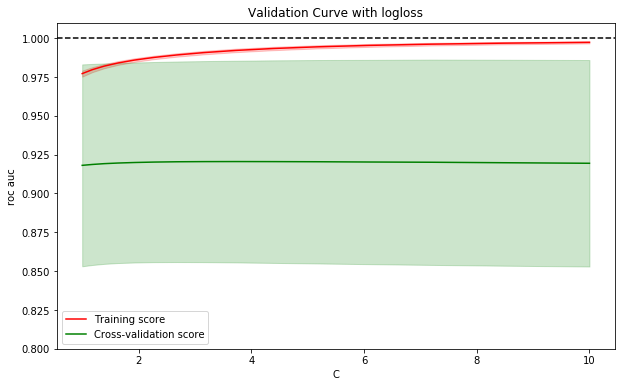

In [50]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

fig = plt.figure(figsize=(10, 6))

plt.title("Validation Curve with logloss")
plt.xlabel("C")
plt.ylabel("roc auc")


plt.plot(c_values,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(c_values,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")
plt.fill_between(c_values,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")
plt.ylim(0.8, 1.01)

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")

### Пишем ответы в файл

In [ ]:
logit = LogisticRegression(random_state=SEED, C = 3.9810717055349722)
logit.fit(X_train_final,y_train)
test_pred = logit.predict_proba(X_test_final)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

# Что не сработало

Очевидно, из-за слишком большого количества признаков не сработали деревья (XGB, CatBoost, Random Forest). Так же не сработали некоторые признаки, которые можно было получить исходя из времени. Определение наиболее часто посещаемых взломщиками сайтов и добавление их в качестве признака, так же не дало прироста. Кодирование категориальных признаков методом One Hot Encoding, а так же кодирование средним (Mean Target - кодирование),в том числе сглаженным, не сработало. Данные подходы не сработали, поскольку в одной модели были как и разряженные признаки, соответствующие сайтам и их н-граммам, так и категориальные признаки полученные из времени посещения сайтов.
Были попытки ассамблировать модели, построенные на разных данных - первая модель - представленная выше, остальные модели - деревья и регрессии построенные на признаках, которые были сгенерированы из времени, включающие двойные интеракции, кодирование среднем и One Hot Encoding. Лучшая модель, построенная только на признаках, сгенерированных из времени давала скор 0.9. В качестве окончательного результата при ассамблировании использывались среднии значения моделей, максимальные, минимальные, но это не дало прироста. Стекинг из 5 моделей на первом уровне так же не дал прироста.

# Итог - 0.95433  (top 16%)